# Final Project - Basics of deep learning - Image retrieval


---
<br>

### Name and ID:
Student 1: Hod Haim ID 209369941
<br>


**SECTION 1: IMPORT LIBRARIES**


In [ ]:
# =============================
# SECTION 1: IMPORT LIBRARIES
# =============================

import os
import shutil
import kagglehub
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Install additional dependencies
!pip install ipython-autotime --quiet
!pip install gdown --upgrade --quiet
%load_ext autotime



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.52 s (started: 2025-03-20 18:15:20 +00:00)


**SECTION 2:Explainer && Load and Preprocess Dataset**

In [ ]:
###################################################Explainer#########################################################
!gdown 1N3GIhQPLvEIj-tMAfiJAKQb2AQqF-nkD -O explainer_image_retrival.zip
!unzip -q explainer_image_retrival.zip -d /content/explainer
############################################################################################################################


Downloading...
From: https://drive.google.com/uc?id=1N3GIhQPLvEIj-tMAfiJAKQb2AQqF-nkD
To: /content/explainer_image_retrival.zip
100% 1.50k/1.50k [00:00<00:00, 9.32MB/s]
time: 4.52 s (started: 2025-03-20 16:41:45 +00:00)


In [ ]:
# SECTION 2: Load and Preprocess Dataset
# ======================================


# Step 1: Download metadata file (Excel) from Google Drive
DATASET_ID = "10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS"
DATASET_ZIP = "stanford_cars_with_class_names.zip"
DATASET_EXCEL = "stanford_cars_with_class_names.xlsx"

# Download and unzip dataset metadata
!gdown {DATASET_ID} -O {DATASET_ZIP}
!unzip -q {DATASET_ZIP} -d /content/dataset

# Step 2: Download dataset images from KaggleHub
!mkdir -p /content/dataset
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

# Step 3: Load dataset metadata (Excel)
metadata_path = "/content/dataset/" + DATASET_EXCEL
xls = pd.ExcelFile(metadata_path)

# Load train and test datasets
train_df = pd.read_excel(xls, sheet_name="train")
test_df = pd.read_excel(xls, sheet_name="test")

# Step 4: Load annotations from the `.mat` file
annotations_path = "/content/dataset/cars_annos.mat"
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list
class_names_list = [name[0] for name in class_names[0]]

# Step 5: Extract class labels and image paths
def extract_annotations(df):
    annotations = []
    class_names = np.empty(196, dtype=object)
    for _, row in df.iterrows():
        image_path = row["image"]
        class_num = int(row["class"]) - 1
        class_name = row["ture_class_name"]
        class_names[class_num] = class_name
        annotations.append((image_path, class_num))
    return annotations, class_names

# Extract annotations for train and test sets
train_annotations, train_class_names = extract_annotations(train_df)
test_annotations, test_class_names = extract_annotations(test_df)

# Step 6: Function to extract image paths and labels
def get_image_paths_and_labels(df, dataset_type="cars_train"):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        image_name = row["image"]
        class_num = int(row["class"]) - 1
        image_paths.append(f"/content/dataset/{dataset_type}/{image_name}")
        labels.append(class_num)

    return image_paths, labels

# Extract train and test image paths and labels
train_image_paths, train_labels = get_image_paths_and_labels(train_df, "cars_train")
test_image_paths, test_labels = get_image_paths_and_labels(test_df, "cars_test")

# Print dataset information
print("Dataset Successfully Loaded!")
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Example training image path: {train_image_paths[0]}")
print(f"Sample class names: {train_class_names[:10]}")



Downloading...
From: https://drive.google.com/uc?id=10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS
To: /content/stanford_cars_with_class_names.zip
100% 766k/766k [00:00<00:00, 132MB/s]
replace /content/dataset/stanford_cars_with_class_names.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
mv: cannot stat '/root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/*': No such file or directory
Dataset Successfully Loaded!
Number of training images: 8144
Number of test images: 8041
Example training image path: /content/dataset/cars_train/00001.jpg
Sample class names: ['AM General Hummer SUV 2000' 'Acura RL Sedan 2012' 'Acura TL Sedan 2012'
 'Acura TL Type-S 2008' 'Acura TSX Sedan 2012' 'Acura Integra Type R 2001'
 'Acura ZDX Hatchback 2012' 'Aston Martin V8 Vantage Convertible 2012'
 'Aston Martin V8 Vantage Coupe 2012'
 'Aston Martin Virage Convertible 2012']
time: 1min 11s (started: 2025-03-20 18:15:25 +00:00)


**SECTION 2: DOWNLOAD & LOAD DATASET**

Cars196 - 196 different classes of vehicles

**SECTION 3: Display Random Images with Bounding Boxes**


 Image: 04971.jpg | Class: Nissan 240SX Coupe 1998
   Bounding Box → x1: 110, y1: 133, x2: 565, y2: 368
 Image: 02574.jpg | Class: Dodge Charger SRT-8 2009
   Bounding Box → x1: 527, y1: 299, x2: 1197, y2: 692
 Image: 05010.jpg | Class: Ferrari 458 Italia Convertible 2012
   Bounding Box → x1: 27, y1: 84, x2: 281, y2: 184
 Image: 00517.jpg | Class: Bentley Continental GT Coupe 2007
   Bounding Box → x1: 20, y1: 205, x2: 1008, y2: 694
 Image: 07295.jpg | Class: Audi S4 Sedan 2012
   Bounding Box → x1: 376, y1: 206, x2: 955, y2: 540


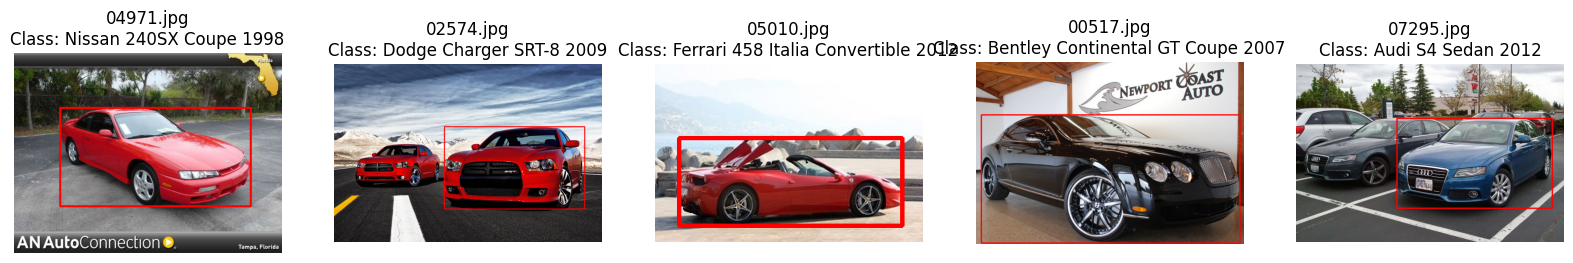

time: 504 ms (started: 2025-03-20 18:16:36 +00:00)


In [ ]:
# SECTION 3: Display Random Images with Annotations
# =====================================================


import cv2
import random


# Select 5 random images
random_samples = random.sample(train_annotations, 5)

def display_images_with_annotations(samples, dataset_path, df):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    if len(samples) < 5:
        print("Not enough images to display.")
        return

    for idx, sample in enumerate(samples):
        if len(sample) < 2:
            print(f"Skipping invalid sample: {sample}")
            continue

        image_name, class_num = sample
        image_path = os.path.join(dataset_path, "cars_train/cars_train", image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract bounding box information from DataFrame
        row = df[df['image'] == image_name]
        if not row.empty:
            x1, y1, x2, y2 = int(row.iloc[0]['x1']), int(row.iloc[0]['y1']), int(row.iloc[0]['x2']), int(row.iloc[0]['y2'])
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw bounding box

            # Display bounding box details
            print(f" Image: {image_name} | Class: {train_class_names[class_num]}")
            print(f"   Bounding Box → x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Display image
        title_text = f"{image_name}\nClass: {train_class_names[class_num]}"
        axes[idx].imshow(image)
        axes[idx].set_title(title_text)
        axes[idx].axis("off")

    plt.show()

# Define dataset path
dataset_path = "/content/dataset"
display_images_with_annotations(random_samples, dataset_path, train_df)


**SECTION 3.5 : Display Test images with real Classes from Excel**

Image: 03684.jpg | Class #22 → Audi S5 Coupe 2012
Image: 03546.jpg | Class #186 → Toyota Sequoia SUV 2012
Image: 06253.jpg | Class #114 → Ford F-150 Regular Cab 2007
Image: 04975.jpg | Class #156 → Lincoln Town Car Sedan 2011
Image: 03963.jpg | Class #119 → GMC Savana Van 2012


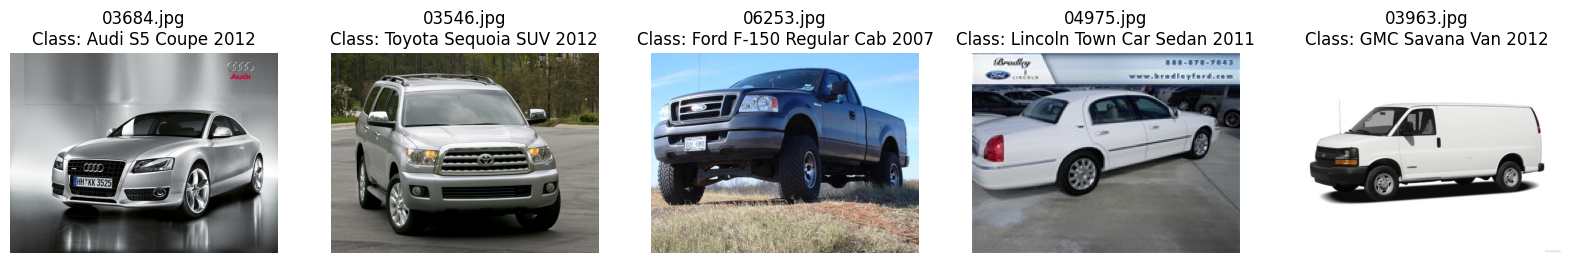

time: 1.46 s (started: 2025-03-20 18:16:37 +00:00)


In [ ]:

# Load the test dataset from Excel
metadata_path = "/content/dataset/stanford_cars_with_class_names.xlsx"
xls = pd.ExcelFile(metadata_path)
test_df = pd.read_excel(xls, sheet_name="test")

# Fix image names (remove extra quotes if they exist)
test_df["image"] = test_df["image"].astype(str).str.replace("'", "")

# Define dataset path for test images
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"

# Function to display random test images
def display_random_test_images(df, dataset_path, num_samples=5):
    """
    Displays random test images along with their class names.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    # Select random images
    samples = df.sample(n=num_samples, random_state=random.randint(0, 10000))

    for idx, (_, row) in enumerate(samples.iterrows()):
        image_name = row["image"]
        image_path = os.path.join(dataset_path, image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract class information
        class_name = row["ture_class_name"]
        class_num = int(row["class"])

        # Print image details
        print(f"Image: {image_name} | Class #{class_num} → {class_name}")

        # Display image
        title_text = f"{image_name}\nClass: {class_name}"
        axes[idx].imshow(image)
        axes[idx].set_title(title_text)
        axes[idx].axis("off")

    plt.show()

# Display random test images
display_random_test_images(test_df, TEST_IMAGE_PATH, num_samples=5)


**SECTION 3.8: Import Model (From Notebook 1)**


In [ ]:
# Step 1: Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')  # This will prompt you to authorize access to your Google Drive

# Step 2: Import required libraries
import gdown

from tensorflow.keras.models import load_model

# Step 3: Download the model from Google Drive using its file ID

file_id = "1Df51xuRyJ2Vz9ZiwxBweTK3NUXwko2ZG"  # Replace with your file ID
output_path = "/content/car_classification_model.h5"  # Path where the model will be saved

# Download the file from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

# Step 4: Load the model
model_path = "/content/car_classification_model.h5"  # The path to the saved model
custom_model = load_model(model_path)  # Load the model using TensorFlow's load_model function

print("Model loaded successfully!")

custom_model.summary()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=1Df51xuRyJ2Vz9ZiwxBweTK3NUXwko2ZG
From (redirected): https://drive.google.com/uc?id=1Df51xuRyJ2Vz9ZiwxBweTK3NUXwko2ZG&confirm=t&uuid=569184f9-4a56-46fe-a91d-725d0356ef12
To: /content/car_classification_model.h5
100%|██████████| 181M/181M [00:01<00:00, 123MB/s]


Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,826,694 (94.71 MB)

 Trainable params: 10,166,212 (38.78 MB)

 Non-trainable params: 14,660,480 (55.93 MB)

 Optimizer params: 2 (12.00 B)

time: 7.4 s (started: 2025-03-20 18:16:45 +00:00)


**SECTION 4: Build Embedding Model (ResNet50)**


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import numpy as np
import os
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# ==========================================
# Step 1: Extract Feature Embeddings
# ==========================================

# Define image size (update if needed)
IMG_SIZE = (224, 224)

# Define paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"

TRAIN_FEATURES_PATH = "/content/train_embeddings.pkl"
TEST_FEATURES_PATH = "/content/test_embeddings.pkl"

# Extract embeddings from ResNet50 model
embedding_layer = custom_model.get_layer("global_average_pooling2d")
embedding_model = Model(inputs=custom_model.input, outputs=embedding_layer.output)

# Freeze layers (not training, just extracting features)
for layer in embedding_model.layers:
    layer.trainable = False

print(" Custom embedding model is ready.")

# ===============================
# Function: Preprocess Image
# ===============================
def preprocess_image(image_path):
    """Loads, resizes, and normalizes an image for ResNet50."""
    try:
        image = load_img(image_path, target_size=IMG_SIZE)  # Load & resize
        image = img_to_array(image)  # Convert to NumPy array
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        image = tf.keras.applications.resnet50.preprocess_input(image)  # Normalize for ResNet50
        return image
    except Exception as e:
        print(f" Error processing image {image_path}: {e}")
        return None

# ===============================
#  Step 2: Extract Features from Images
# ===============================
def extract_features_from_df(df, dataset_path):
    """Extracts feature embeddings from images listed in a DataFrame."""
    feature_list, valid_labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
        try:
            image_name = row["image"]
            image_path = os.path.join(dataset_path, image_name)

            if not os.path.exists(image_path):
                print(f" Image not found: {image_path}")
                continue

            image = preprocess_image(image_path)
            if image is None:
                continue

            feature_vector = embedding_model.predict(image, verbose=0).flatten()
            feature_list.append(feature_vector)
            valid_labels.append(int(row["class"]) - 1)  # Convert labels to zero-based index

        except Exception as e:
            print(f" Error processing {image_path}: {e}")

    return np.array(feature_list), np.array(valid_labels)

# ===============================
# Step 3: Save & Load Features
# ===============================
def save_features_to_pickle(features, labels, file_path):
    """Saves extracted features and labels to a pickle file."""
    with open(file_path, "wb") as f:
        pickle.dump({"features": features, "labels": labels}, f)
    print(f" Features saved to {file_path}")

def load_features_from_pickle(file_path):
    """Loads extracted features and labels from a pickle file."""
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data["features"], data["labels"]

# ===============================
#  Step 4: Extract & Save Train & Test Features
# ===============================
print("Extracting features for training images...")
train_features, train_labels = extract_features_from_df(train_df, TRAIN_IMAGE_PATH)
save_features_to_pickle(train_features, train_labels, TRAIN_FEATURES_PATH)

print("Extracting features for test images...")
test_features, test_labels = extract_features_from_df(test_df, TEST_IMAGE_PATH)
save_features_to_pickle(test_features, test_labels, TEST_FEATURES_PATH)


print(f"Feature matrix shape: {train_features.shape}")  # Should be (num_images, feature_dim)
print(f"Labels shape: {train_labels.shape}")  # Should be (num_images,)
print(f"First feature vector: {train_features[0][:10]}")  # Print first 10 values of the first image embedding
print(f"First label: {train_labels[0]}")  # Should be an integer label

 Custom embedding model is ready.
Extracting features for training images...


Processing Images: 100%|██████████| 8144/8144 [11:48<00:00, 11.50it/s]


 Features saved to /content/train_embeddings.pkl
Extracting features for test images...


Processing Images: 100%|██████████| 8041/8041 [11:47<00:00, 11.36it/s]


 Features saved to /content/test_embeddings.pkl
Feature matrix shape: (8144, 2048)
Labels shape: (8144,)
First feature vector: [0.18902098 0.63359326 0.16149937 0.76660323 0.35342866 0.24884285
 0.15930648 0.09964571 0.2336312  1.6331438 ]
First label: 13
time: 23min 36s (started: 2025-03-20 18:17:03 +00:00)


**Step 5: Train & Evaluate KNN with Multiple k Values**


In [ ]:
def evaluate_knn_with_visuals(k_values, train_features, train_labels, test_features, test_labels, test_df):
    """
    Trains and evaluates KNN for different k values, prints results, and visualizes predictions.
    """
    accuracy_scores = {}  # Store accuracy scores for plotting

    for k in k_values:
        print(f"\nEvaluating KNN with k={k}...")

        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
        knn.fit(train_features, train_labels)

        # Predict on test set
        predicted_labels = knn.predict(test_features)

        # Compute accuracy
        accuracy = accuracy_score(test_labels, predicted_labels)
        accuracy_scores[k] = accuracy  # Store accuracy for graph

        print(f"Accuracy for k={k}: {accuracy:.4f}")

        # Display 5 sample test images with predictions
        print("\nShowing 5 sample test images with predictions:")
        random_indices = random.sample(range(len(test_labels)), 5)  # Select 5 random test images

        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i, idx in enumerate(random_indices):
            image_path = os.path.join(TEST_IMAGE_PATH, test_df.iloc[idx]["image"])
            image = load_img(image_path, target_size=(224, 224))

            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"Pred: {predicted_labels[idx]}\nReal: {test_labels[idx]}", fontsize=10)

        plt.show()  # Show images with predictions

    return accuracy_scores  # Return accuracy results for plotting


time: 990 µs (started: 2025-03-20 18:42:30 +00:00)


**Step 6: Run Evaluation for k = 10, 5, and 1**


Evaluating KNN with k=1...
Accuracy for k=1: 0.5797

Showing 5 sample test images with predictions:


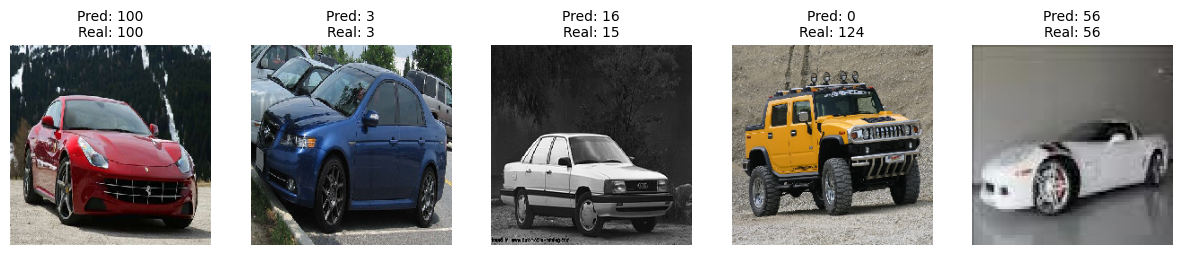


Evaluating KNN with k=5...
Accuracy for k=5: 0.5912

Showing 5 sample test images with predictions:


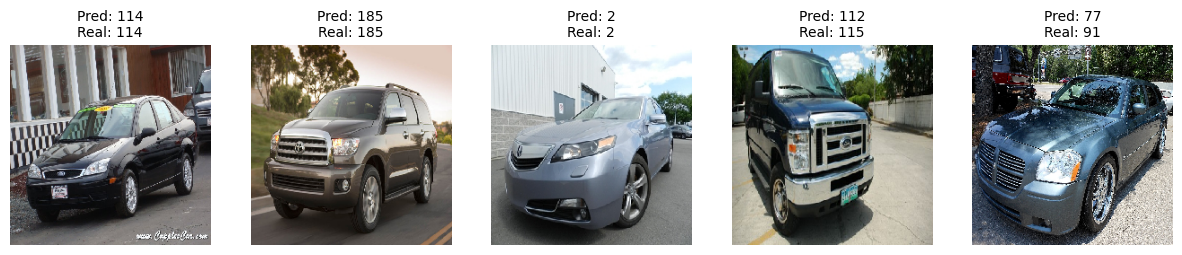


Evaluating KNN with k=10...
Accuracy for k=10: 0.6045

Showing 5 sample test images with predictions:


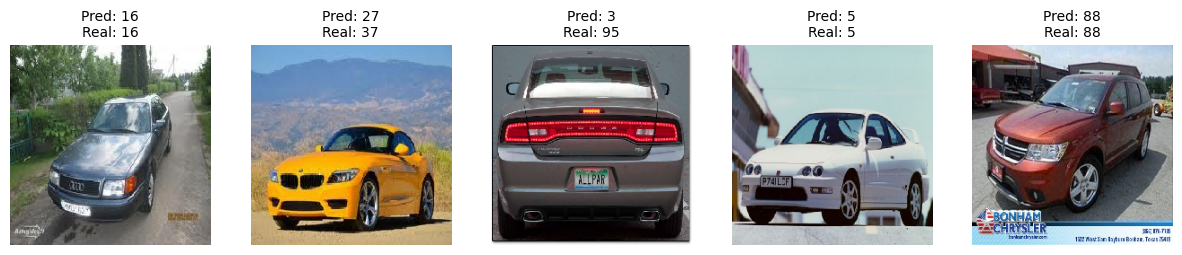


Reasults been saved
time: 6.49 s (started: 2025-03-20 18:42:32 +00:00)


In [ ]:
# Define k values to test
k_values = [1, 5, 10]

# Load saved features
train_features, train_labels = load_features_from_pickle(TRAIN_FEATURES_PATH)
test_features, test_labels = load_features_from_pickle(TEST_FEATURES_PATH)

# Run KNN evaluation and store accuracy results
accuracy_results = evaluate_knn_with_visuals(k_values, train_features, train_labels, test_features, test_labels, test_df)

import numpy as np

np.save("accuracy_results.npy", accuracy_results)

print("\nReasults been saved")




**Step 7: Plot Accuracy Comparison**

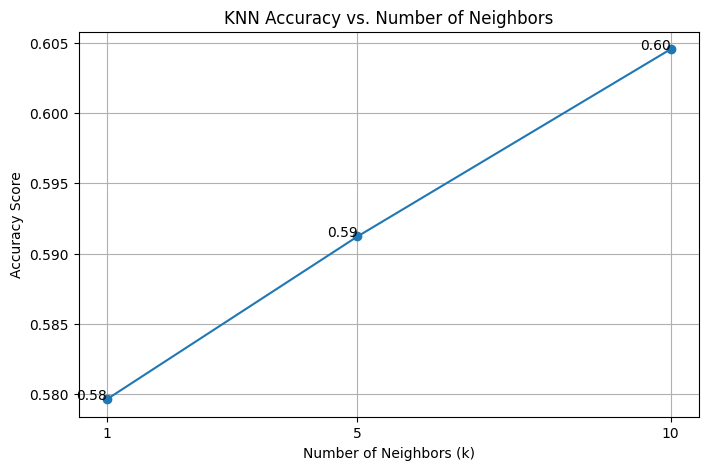

time: 111 ms (started: 2025-03-20 18:42:42 +00:00)


In [ ]:
def plot_accuracy_results(accuracy_results):
    """
    Plots accuracy results for different k values.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(list(accuracy_results.keys()), list(accuracy_results.values()), marker='o', linestyle='-')

    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy Score")
    plt.title("KNN Accuracy vs. Number of Neighbors")
    plt.xticks(list(accuracy_results.keys()))
    plt.grid(True)

    for k, acc in accuracy_results.items():
        plt.text(k, acc, f"{acc:.2f}", ha='right', fontsize=10)

    plt.show()

# Plot results
plot_accuracy_results(accuracy_results)


**SECTION 7.5: Evaluate Top-1 and Top-5 Accuracy for KNN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# ===============================
#  SECTION 7.5: Evaluate Top-1 and Top-5 Accuracy for KNN
# ===============================
def evaluate_knn_top_accuracies(k_values, train_features, train_labels, test_features, test_labels):
    """
    Trains KNN for different k values and evaluates Top-1 and Top-5 accuracy.
    """
    top1_accuracies = {}
    top5_accuracies = {}

    for k in k_values:
        print(f"\n Evaluating KNN with k={k}...")

        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
        knn.fit(train_features, train_labels)

        # Get Top-1 predictions
        predicted_labels = knn.predict(test_features)
        top1_accuracy = accuracy_score(test_labels, predicted_labels)

        # Get Top-5 predictions using predict_proba()
        if hasattr(knn, 'predict_proba'):
            probabilities = knn.predict_proba(test_features)
            top5_accuracy = top_k_accuracy_score(test_labels, probabilities, k=5, labels=np.arange(len(np.unique(train_labels))))
        else:
            top5_accuracy = 0  # If predict_proba is not available, set top-5 accuracy to 0

        top1_accuracies[k] = top1_accuracy
        top5_accuracies[k] = top5_accuracy

        print(f"Top-1 Accuracy for k={k}: {top1_accuracy:.4f}")
        print(f"Top-5 Accuracy for k={k}: {top5_accuracy:.4f}")

    return top1_accuracies, top5_accuracies

# Run Top-1 and Top-5 Accuracy evaluation
k_values = [1, 5, 10]
top1_results, top5_results = evaluate_knn_top_accuracies(k_values, train_features, train_labels, test_features, test_labels)



 Evaluating KNN with k=1...
Top-1 Accuracy for k=1: 0.5797
Top-5 Accuracy for k=1: 0.5866

 Evaluating KNN with k=5...
Top-1 Accuracy for k=5: 0.5912
Top-5 Accuracy for k=5: 0.7871

 Evaluating KNN with k=10...
Top-1 Accuracy for k=10: 0.6045
Top-5 Accuracy for k=10: 0.8074
time: 9.75 s (started: 2025-03-20 18:42:48 +00:00)


**SECTION 8: Plot Top-1 and Top-5 Accuracy Comparison**

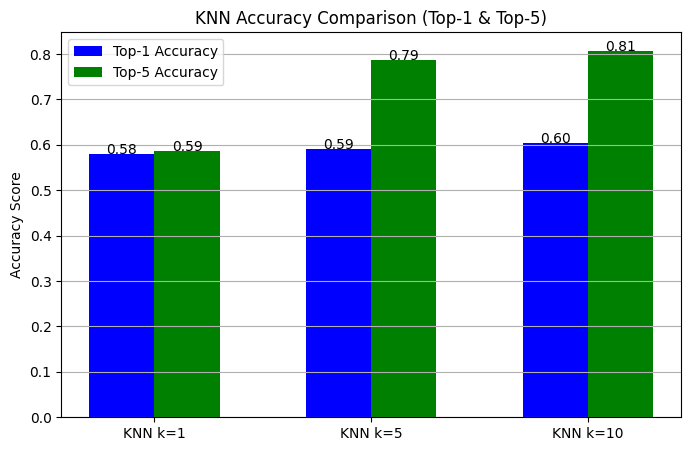

time: 147 ms (started: 2025-03-20 18:44:15 +00:00)


In [ ]:

# ===============================
# SECTION 8: Plot Top-1 and Top-5 Accuracy Comparison
# ===============================
def plot_knn_accuracy_comparison(k_values, top1_results, top5_results):
    """
    Plots comparison of Top-1 and Top-5 accuracy for different KNN models.
    """
    plt.figure(figsize=(8, 5))
    x = np.arange(len(k_values))
    width = 0.3  # Bar width

    plt.bar(x - width/2, [top1_results[k] for k in k_values], width=width, label="Top-1 Accuracy", color="blue")
    plt.bar(x + width/2, [top5_results[k] for k in k_values], width=width, label="Top-5 Accuracy", color="green")

    plt.xticks(x, [f"KNN k={k}" for k in k_values])
    plt.ylabel("Accuracy Score")
    plt.title("KNN Accuracy Comparison (Top-1 & Top-5)")
    plt.legend()
    plt.grid(axis="y")

    for i, k in enumerate(k_values):
        plt.text(i - width/2, top1_results[k], f"{top1_results[k]:.2f}", ha='center', fontsize=10)
        plt.text(i + width/2, top5_results[k], f"{top5_results[k]:.2f}", ha='center', fontsize=10)

    plt.show()

# Plot results
plot_knn_accuracy_comparison(k_values, top1_results, top5_results)
